In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score


%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline



In [3]:
from google.colab import files
uploaded = files.upload()

Saving Titanic_full.csv to Titanic_full.csv


In [6]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Titanic_full.csv']))

In [7]:
cols = list(df.columns)
df.shape

(1309, 12)

In [8]:
def df_splitter(df,num_rows):
    return df[:num_rows].copy(),df[num_rows:]

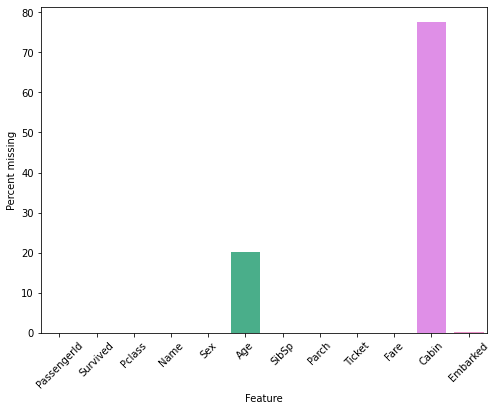

In [9]:
null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [10]:
df = df.drop("Cabin",axis = 1)
print(df.shape)
df.head(2)
df.info()

(1309, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


In [11]:
def str_to_cat(df):
    for p,q in df.items():
        if is_string_dtype(q): 
            df[p] = q.astype('category').cat.as_ordered()
    return df
def df_to_nums(df, feature, null_status):
    if not is_numeric_dtype(feature):
        df[null_status] = feature.cat.codes + 1
        
def df_imputer(df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def df_preprocessor(df, null_table):
    
    if null_table is None: 
        null_table = dict()
    for p,q in df.items(): 
        null_table = df_imputer(df, q, p, null_table)
        #print(p+" "+q)
    for p,q in df.items(): 
        df_to_nums(df, q, p)
    df = pd.get_dummies(df, dummy_na = True)
    res = [df, null_table]
    return res
#df = str_to_cat(df)
#df,my_table = df_preprocessor(df,null_table = None)
#print(df)
#print(my_table)

In [12]:
df = str_to_cat(df)

In [13]:
my_df,my_table = df_preprocessor(df,null_table = None)
my_df.info()
my_table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   int16  
 4   Sex          1309 non-null   int8   
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   int16  
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   int8   
 11  Age_na       1309 non-null   bool   
 12  Fare_na      1309 non-null   bool   
dtypes: bool(2), float64(2), int16(2), int64(5), int8(2)
memory usage: 81.9 KB


{'Age': 28.0, 'Fare': 14.4542}

In [14]:
Y = my_df["Survived"]
X = my_df.drop(["Survived"],axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   int16  
 3   Sex          1309 non-null   int8   
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   int16  
 8   Fare         1309 non-null   float64
 9   Embarked     1309 non-null   int8   
 10  Age_na       1309 non-null   bool   
 11  Fare_na      1309 non-null   bool   
dtypes: bool(2), float64(2), int16(2), int64(4), int8(2)
memory usage: 71.7 KB


In [15]:
from sklearn import preprocessing
X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)

scaler = preprocessing.MinMaxScaler()
X_con_sc = pd.DataFrame(scaler.fit_transform(X_con))
print(X_con_sc)
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc)
df_list = [X_cat,X_con_sc]
print(len((df_list)))
print(df_list)
X_full = pd.concat(df_list,axis = 1)
print(X_full)

             0         1
0     0.273456  0.014151
1     0.473882  0.139136
2     0.323563  0.015469
3     0.436302  0.103644
4     0.436302  0.015713
...        ...       ...
1304  0.348616  0.015713
1305  0.486409  0.212559
1306  0.480145  0.014151
1307  0.348616  0.015713
1308  0.348616  0.043640

[1309 rows x 2 columns]
           Age      Fare
0     0.273456  0.014151
1     0.473882  0.139136
2     0.323563  0.015469
3     0.436302  0.103644
4     0.436302  0.015713
...        ...       ...
1304  0.348616  0.015713
1305  0.486409  0.212559
1306  0.480145  0.014151
1307  0.348616  0.015713
1308  0.348616  0.043640

[1309 rows x 2 columns]
2
[      PassengerId  Pclass  Name  Sex  SibSp  Parch  Ticket  Embarked  Age_na  \
0               1       3   156    2      1      0     721         3   False   
1               2       1   287    1      1      0     817         1   False   
2               3       3   524    1      0      0     915         3   False   
3               4       1  

In [16]:
X_con_sc.describe()

,Age,Fare
count,1309.000000,1309.000000
mean,0.367446,0.064960
std,0.161659,0.100993
min,0.000000,0.000000
25%,0.273456,0.015412
50%,0.348616,0.028213
75%,0.436302,0.061045
max,1.000000,1.000000


In [17]:
(X_train, X_valid, Y_train, Y_valid) = train_test_split(X, Y, train_size=0.85, random_state=1)

<h1> Random Forest </h1>

In [18]:
rf_model = RandomForestClassifier(n_jobs = -1,oob_score = False,n_estimators = 10,
                                   max_depth = 40000,min_samples_leaf = 25)
rf_model.fit(X_train,Y_train)

RandomForestClassifier(max_depth=40000, min_samples_leaf=25, n_estimators=10,
                       n_jobs=-1)

In [19]:
rf_Y_pred = rf_model.predict(X_valid)

In [20]:
from sklearn.metrics import r2_score
#
accuracy_score(rf_Y_pred,Y_valid)

0.6649746192893401

<h1> DNN </h1>

In [21]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_sc = pd.DataFrame(scaler.transform(X))
print(X_sc.shape)
X_sc.head(2)



(1309, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.730728,0.841916,-1.319550,0.743497,-0.581628,0.481288,-0.445,0.922332,-0.503291,0.623648,-0.501432,-0.02765
1,-1.728082,-1.546098,-0.972223,-1.344995,0.658652,0.481288,-0.445,1.267701,0.734744,-1.816877,-0.501432,-0.02765


In [22]:
X_train,X_valid = df_splitter(X_sc,700)
Y_train,Y_valid = df_splitter(Y,700)
print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(700, 12) (609, 12) (700,) (609,)


In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
DNN_model = Sequential()
DNN_model.add(Dense(5, kernel_initializer="glorot_uniform", activation='relu'))
DNN_model.add(Dense(6, kernel_initializer="random_normal",activation='relu'))
DNN_model.add(Dense(1, kernel_initializer="glorot_uniform",activation='sigmoid'))


In [24]:
DNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
X_cols=X_train.columns
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_valid = np.asarray(X_valid).astype(np.float32)
Y_valid = np.asarray(Y_valid).astype(np.float32)

In [25]:
DNN_model_gr= DNN_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=100, batch_size=5)

Epoch 1/100
140/140 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.6086 - val_loss: 0.6737 - val_accuracy: 0.6026
Epoch 2/100
140/140 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.6500 - val_loss: 0.6658 - val_accuracy: 0.5878
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7157 - val_loss: 0.6745 - val_accuracy: 0.5895
Epoch 4/100
140/140 [==============================] - 0s 2ms/step - loss: 0.5376 - accuracy: 0.7657 - val_loss: 0.6935 - val_accuracy: 0.5977
Epoch 5/100
140/140 [==============================] - 0s 2ms/step - loss: 0.5010 - accuracy: 0.7829 - val_loss: 0.7084 - val_accuracy: 0.6108
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.7900 - val_loss: 0.7167 - val_accuracy: 0.6108
Epoch 7/100
140/140 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7986 - val_loss: 0.7270 - val_accuracy: 0.6076

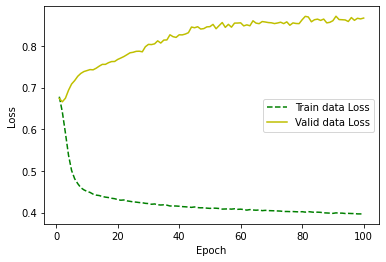

In [26]:
import matplotlib.pyplot as plt
training_loss = DNN_model_gr.history['loss']
test_loss = DNN_model_gr.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'g--')
plt.plot(epoch_count, test_loss, 'y-')
plt.legend(['Train data Loss', 'Valid data Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

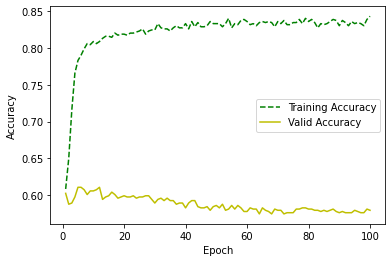

In [27]:
training_loss = DNN_model_gr.history['accuracy']
test_loss = DNN_model_gr.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'g--')
plt.plot(epoch_count, test_loss, 'y-')
plt.legend(['Training Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [28]:
scores = DNN_model.evaluate(X_valid, Y_valid)
print ("Accuracy: %.2f%%" %(scores[1]*100))

20/20 [==============================] - 0s 1ms/step - loss: 0.8668 - accuracy: 0.5796
Accuracy: 57.96%


<h1> Hybrid DNN/Random Forest </h1>

<p> We are creating a hybrid RF/DNN model by first training the model using the Random Forest and getting the most important features. </p>
<p> This is then passed to the DNN. </p>

In [29]:
rf_model_hybrid = RandomForestClassifier(n_jobs = -1, n_estimators = 5,bootstrap = True)
rf_model_hybrid.fit(X_train,Y_train)


RandomForestClassifier(n_estimators=5, n_jobs=-1)

In [30]:
Y_pred_hybrid = rf_model_hybrid.predict(X_valid)
accuracy_score(Y_valid,Y_pred_hybrid)

0.5927750410509032

RangeIndex(start=0, stop=12, step=1)


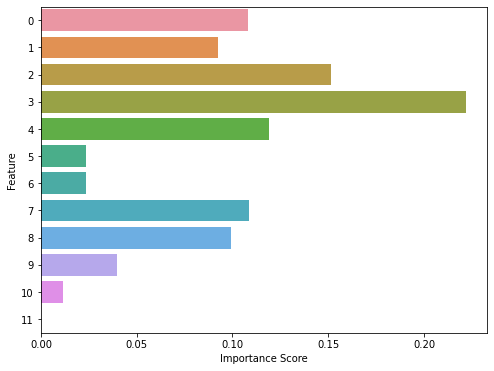

In [31]:
X_train=pd.DataFrame(X_train)
X_train.columns=X_cols
X_valid=pd.DataFrame(X_valid)
X_valid.columns=X_cols
print(X_train.columns)
feat_imps = pd.DataFrame(rf_model_hybrid.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [32]:
print(X_train.columns)


RangeIndex(start=0, stop=12, step=1)


In [33]:
X_train_hybrid=X_train[[0,1,2,3,4,7,8]]
X_valid_hybrid=X_valid[[0,1,2,3,4,7,8]]
X_valid_hybrid.shape
Y_valid.shape

(609,)

In [34]:
DNN_model_init = Sequential()
DNN_model_init.add(Dense(12, kernel_initializer="glorot_uniform", activation='relu'))
DNN_model_init.add(Dense(5, kernel_initializer="random_normal",activation='relu'))
DNN_model_init.add(Dense(1, kernel_initializer="glorot_uniform",activation='sigmoid'))

In [35]:
DNN_model_init.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
DNN_model_hybrid= DNN_model_init.fit(X_train_hybrid, Y_train, validation_data=(X_valid_hybrid, Y_valid), epochs=150, batch_size=5)

Epoch 1/150
140/140 [==============================] - 1s 3ms/step - loss: 0.6477 - accuracy: 0.7129 - val_loss: 0.6680 - val_accuracy: 0.6108
Epoch 2/150
140/140 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.7914 - val_loss: 0.6669 - val_accuracy: 0.5993
Epoch 3/150
140/140 [==============================] - 0s 2ms/step - loss: 0.4910 - accuracy: 0.7914 - val_loss: 0.6973 - val_accuracy: 0.5961
Epoch 4/150
140/140 [==============================] - 0s 2ms/step - loss: 0.4717 - accuracy: 0.7943 - val_loss: 0.7107 - val_accuracy: 0.6108
Epoch 5/150
140/140 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7857 - val_loss: 0.7213 - val_accuracy: 0.6059
Epoch 6/150
140/140 [==============================] - 0s 2ms/step - loss: 0.4586 - accuracy: 0.7943 - val_loss: 0.7340 - val_accuracy: 0.6026
Epoch 7/150
140/140 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7957 - val_loss: 0.7397 - val_accuracy: 0.6010

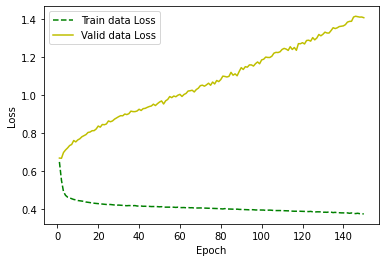

In [37]:
import matplotlib.pyplot as plt
training_loss = DNN_model_hybrid.history['loss']
test_loss = DNN_model_hybrid.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'g--')
plt.plot(epoch_count, test_loss, 'y-')
plt.legend(['Train data Loss', 'Valid data Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

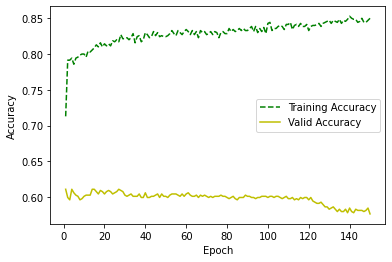

In [38]:
training_loss = DNN_model_hybrid.history['accuracy']
test_loss = DNN_model_hybrid.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'g--')
plt.plot(epoch_count, test_loss, 'y-')
plt.legend(['Training Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();


In [39]:
eval_result = DNN_model_init.evaluate(X_valid_hybrid, Y_valid)
print("[test loss, test accuracy]:", eval_result)

20/20 [==============================] - 0s 1ms/step - loss: 1.4073 - accuracy: 0.5764
[test loss, test accuracy]: [1.4073067903518677, 0.5763546824455261]


<h2> Accuracy of RF: 70.05% </h2>
<h2> Accuracy of DNN: 60.43% </h2>
<h2> Accuracy of hybrid RF/DNN: 53.53% </h2>

<p>Ensemble learning strategies include bagging and boosting.</p>
<p>Through bagging, many subsets are created from the original data. It further seeks to decrease variance by generating more data for training. The average output of the N learners is used to calculate the outcome after each of these subsets is used to construct a weak model (weak models).</p>
<p>
Boosting is a sequential process where subsequent models learn from the mistakes of the preceding models. Data items that are incorrectly classified are given extra weight. The models that perform well with that subset of the input data are largely what determine which data point becomes the final output.</p>